## Data Loading

In [1]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import pandas as pd
import numpy as np
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

df = pd.read_csv("avocado.csv")
df.head(3)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany


In [2]:
# Index and sort data by Date
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)
df.sort_values(by=['Date'], inplace=True)

## Data Exploration

### Organic vs. Conventional

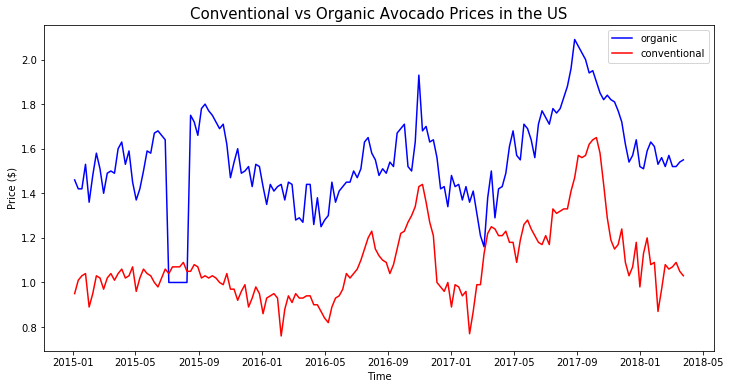

In [3]:
organic = df.loc[(df['region'] == "TotalUS") & (df['type'] == "organic")]
conv = df.loc[(df['region'] == "TotalUS") & (df['type'] == "conventional")]

plt.figure(figsize=(12,6))
plt.plot(organic.index, organic['AveragePrice'], label="organic", color='b')
plt.plot(conv.index, conv['AveragePrice'], label="conventional", color='r')
plt.legend()
plt.title("Conventional vs Organic Avocado Prices in the US", fontsize=15)
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.show()

#### We can observe that:
1. Generally, organic and conventional avocado prices have similar fluctuations.
2. There is a sudden drop in organic prices in August 2015.

### New York vs. Boston vs. Dallas vs. Total US

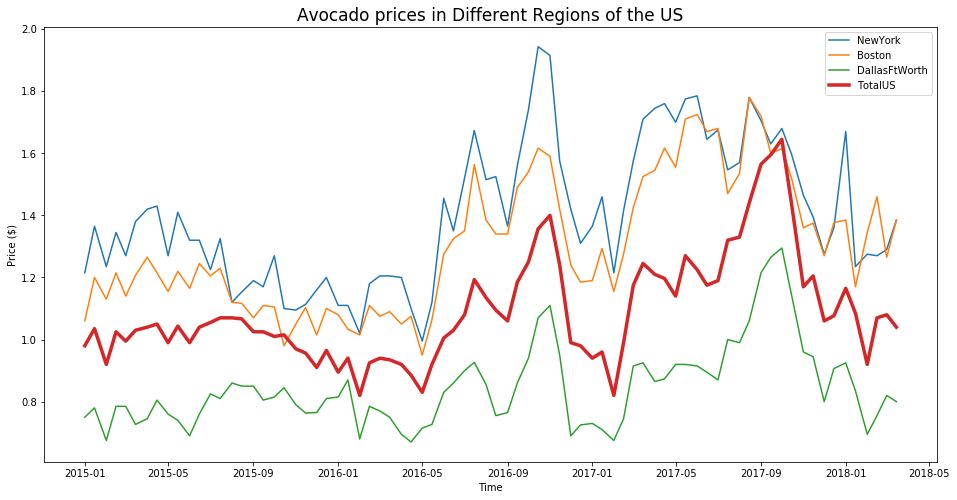

In [4]:
conventional = df.loc[df['type'] == "conventional"]

plt.figure(figsize=(16,8))

cities = ["NewYork", "Boston", "DallasFtWorth", "TotalUS"]
for c in cities:
    data = conventional.loc[conventional['region'] == c]
    data = data['AveragePrice'].resample("SMS").mean()
    if c == "TotalUS":
        linewidth = 3.5
    else:
        linewidth = 1.5
    plt.plot(data.index, data, label=c, linewidth=linewidth)

plt.legend()
plt.title("Avocado prices in Different Regions of the US", fontsize=17)
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.show()

- New York has the highest prices
- Dallas has the lowest prices

## Time-series Analysis

In [5]:
# Date range: Jan 2015 to March 2018
conv.index.min(), conv.index.max()

(Timestamp('2015-01-04 00:00:00'), Timestamp('2018-03-25 00:00:00'))

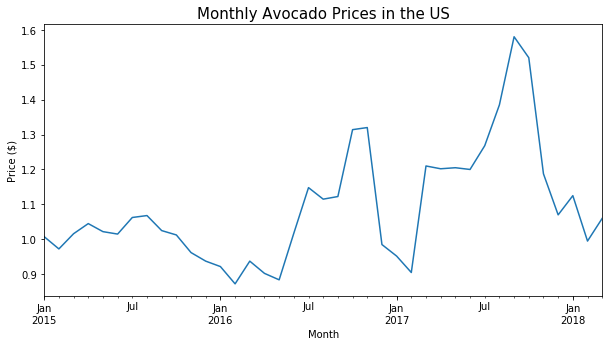

In [6]:
y = conv['AveragePrice'].resample("MS").mean()
plt.figure(figsize=(10,5))
y.plot()
plt.title("Monthly Avocado Prices in the US", fontsize=15)
plt.xlabel("Month")
plt.ylabel("Price ($)")
plt.show()

### Seasonal decomposition

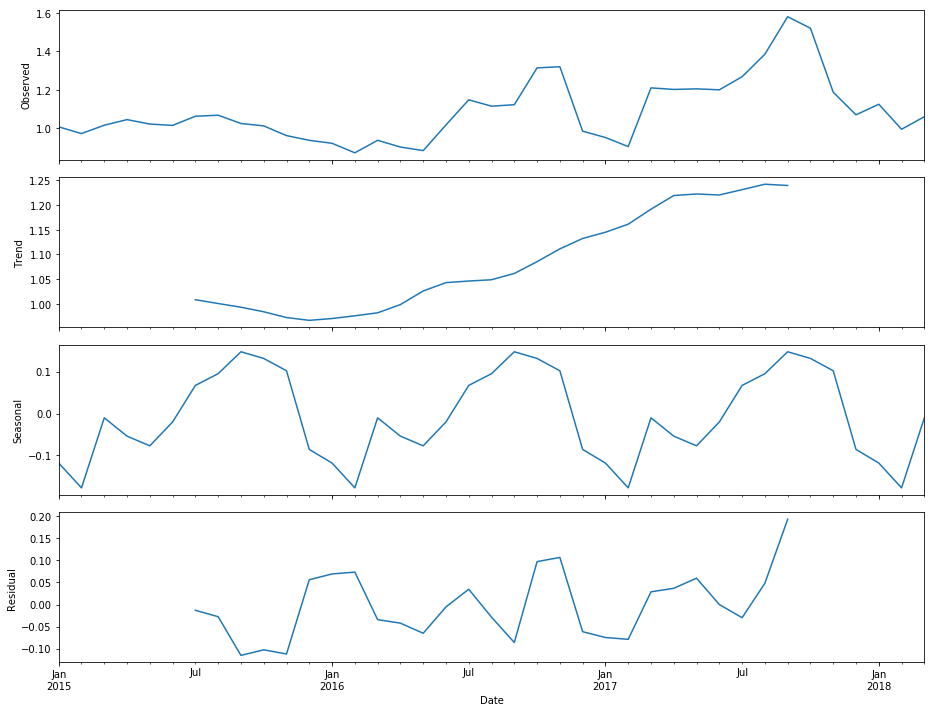

In [7]:
rcParams['figure.figsize'] = 13, 10

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

#### We can observe that
* The fluctuation in prices is *seasonal*
* The trend in price is overall *increasing*

## Predictive Modeling

### Training ARIMA time series model

In [19]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=-1)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:117.48546683830756
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:805.9404826967461
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-8.34771804483495
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-14.734202145704238
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-17.777051846720315
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:0.9583447392638318
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:73.07123549784707
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1282.490002296996
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-20.84433935580845
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-25.127797334484917
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-28.020334161636853
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-9.174386691417766
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-51.58606319577091
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1116.404176343561
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-19.731969656612215
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-26.588439176037337
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-23.758563179677164
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-13.17989

In [9]:
# Check for convergence
results.mle_retvals

{'fopt': -0.20801907028926608,
 'gopt': array([ 7.53017870e-05,  3.13323922e-05,  4.38971165e-05, -3.76407988e-04]),
 'fcalls': 310,
 'warnflag': 0,
 'converged': True,
 'iterations': 27}

#### After 27 iterations, the model converged with the optimal values (1, 1, 1) x (1, 1, 0, 12). We will use this for our predictive model.

In [10]:
model = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.7216,0.315,2.289,0.022,0.104,1.339
ma.L1,-1.0002,116.357,-0.009,0.993,-229.056,227.055
ar.S.L12,-0.6011,0.312,-1.925,0.054,-1.213,0.011
sigma2,0.0125,1.455,0.009,0.993,-2.838,2.863


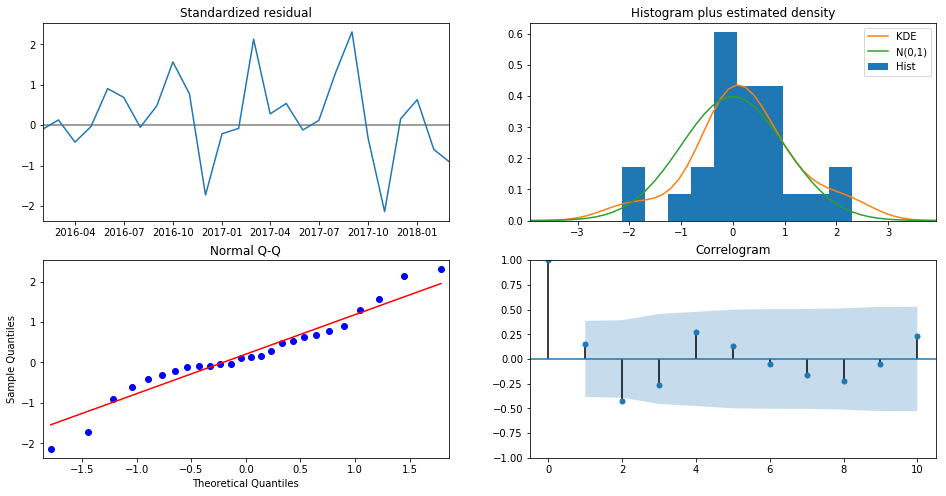

In [11]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### The model residuals do not exactly follow a normal distribution, but they are close to one.

### Predicted prices vs. True prices

#### We use the model above to predict the sale prices of avocados from January 2017 onwards.

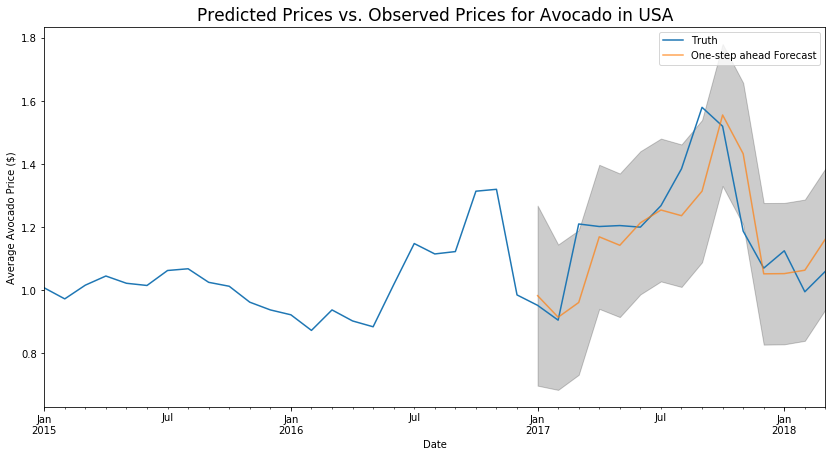

In [12]:
pred_date = '2017-01-01'
pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='Truth')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Avocado Price ($)')
plt.title("Predicted Prices vs. Observed Prices for Avocado in USA", fontsize=17)
plt.legend()
plt.show()

#### Although the forecasted values are not exactly the same, they follow the upward then downward trend of the observed data.

### Evaluation

In [13]:
y_forecasted = pred.predicted_mean
y_truth = y[pred_date:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Mean Squared Error = ${}'.format(round(mse, 5)))
print('Root Mean Squared Error = is ${}'.format(round(np.sqrt(mse), 5)))

Mean Squared Error = $0.01622
Root Mean Squared Error = is $0.12737


### Future Forecasting

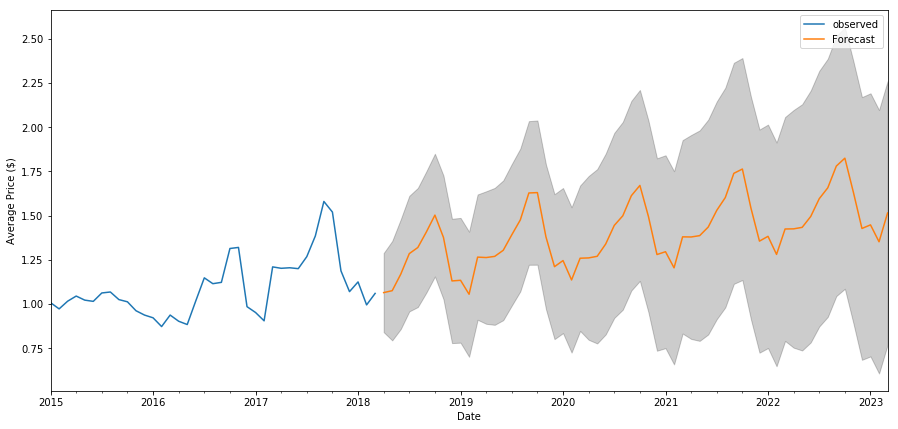

In [14]:
pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(15, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Price ($)')
plt.legend()
plt.show()

#### The predictive model captures both the seasonality and the overall increasing trend of the price values.